# Orientation reanalysis

Recently, I've been analyzing the alignment of active nematics. I realized that this method might be useful in computing the alignment of the bacterial system too. In this notebook, I test an old image and see how it works. 

In [38]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks
plt.rcParams['ytick.major.size'] = 2  # Length of major ticks
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks

In [1]:
def fndstruct(sigma1, sigma2, im):
    """
    Returns the structure tensor orientation of an image.

    Args:
    sigma1 -- gaussian filter sigma for the raw image.
    sigma2 -- gaussian filter sigma for the gradient fields.
    im -- the input image, [M x N].

    Returns:
    director -- the director field of the nematic system, [M x N x 2].
    S -- the magnitude of the Q-tensor, [M x N].
    """
    imgf = gaussian_filter(im, sigma1)

    gx, gy = np.gradient(imgf)

    gxgx = gx * gx
    gxgy = gx * gy
    gygy = gy * gy

    gxgx = gaussian_filter(gxgx, sigma2)
    gxgy = gaussian_filter(gxgy, sigma2)
    gygy = gaussian_filter(gygy, sigma2)

    aa = np.array([[gxgx, gxgy], [gxgy, gygy]])
    eigenvalues, eigenvectors = np.linalg.eig(aa.transpose(2, 3, 0, 1).reshape(-1, 2, 2))
    eigenvalues = eigenvalues.reshape(aa.shape[2], aa.shape[3], 2)
    eigenvectors = eigenvectors.reshape(aa.shape[2], aa.shape[3], 2, 2)

    # Find the indices of the smaller eigenvalues
    indices = np.argmax(eigenvalues, axis=2)

    # Extract the corresponding eigenvectors
    director = np.array([eigenvectors[i, j, :, indices[i, j]] for i in range(eigenvectors.shape[0]) for j in range(eigenvectors.shape[1])])
    director = director.reshape(eigenvectors.shape[0], eigenvectors.shape[1], 2)

    # require the y component director to be positive, otherwise flip the director
    director[director[:,:,1]<=0] *= -1

    return director, np.max(eigenvalues, axis=2)

In [4]:
img = io.imread(r"C:\Users\zl948\Documents\GitHub\manTrack\test_files\test_img.tif")

In [48]:
d, s = fndstruct(1, 10, img)

In [49]:
h, w = img.shape
dpi = 300

(-0.5, 1199.5, 1799.5, -0.5)

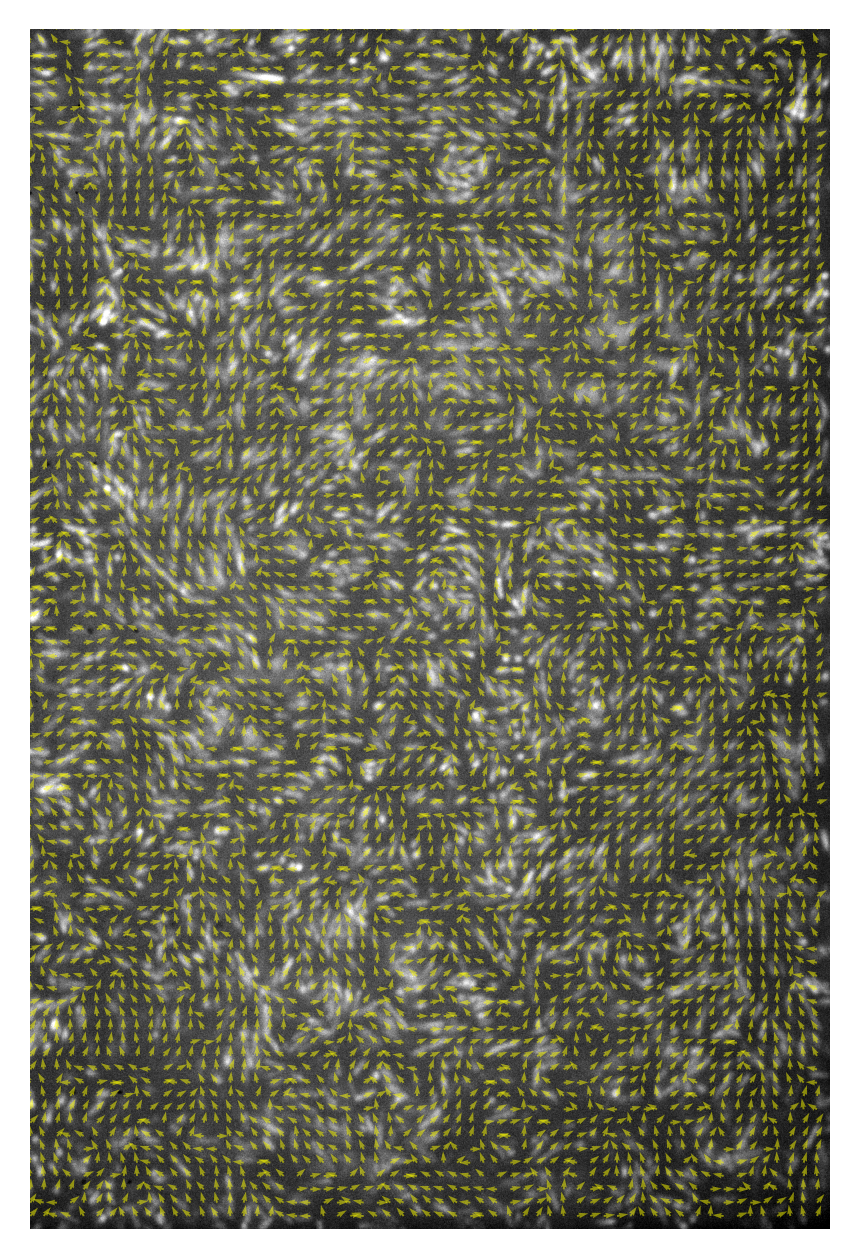

In [50]:
fig = plt.figure(figsize=(h/dpi,w/dpi), dpi=dpi)
ax = fig.add_axes([0,0,1,1])
ax.imshow(img, cmap='gray')
step = 20  # Adjust the step size to make the arrows sparse
Y, X = np.mgrid[0:img.shape[0]:step, 0:img.shape[1]:step]
ax.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], color='yellow', scale=70, alpha=.5)
ax.axis("off")

(-0.5, 1199.5, 1799.5, -0.5)

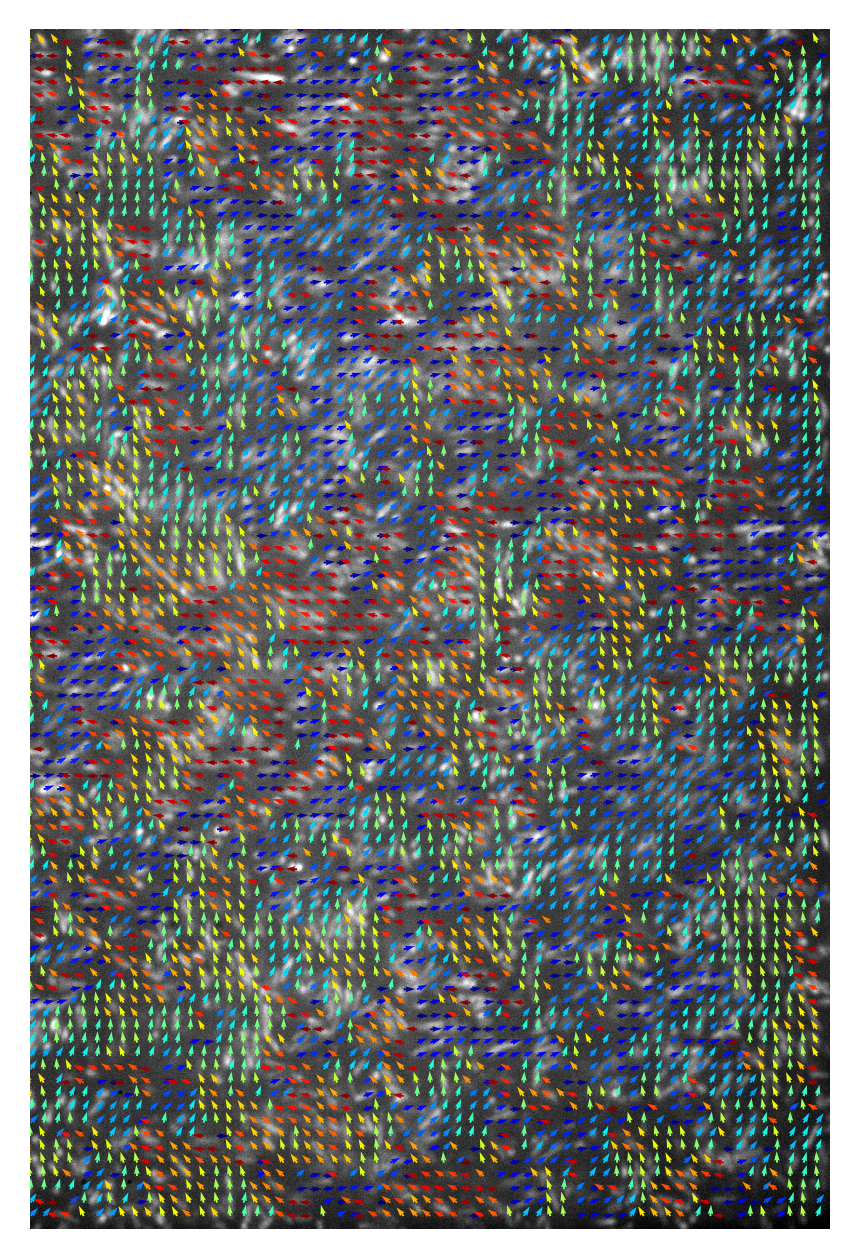

In [47]:
# colro the arrows based on the orientation
fig = plt.figure(figsize=(h/dpi,w/dpi), dpi=dpi)
ax = fig.add_axes([0,0,1,1])
ax.imshow(img, cmap='gray')
ax.quiver(X, Y, d[::step, ::step, 0], d[::step, ::step, 1], np.arctan2(d[::step, ::step, 1], d[::step, ::step, 0]), cmap="jet", scale=70, alpha=1)
ax.axis("off")

In [25]:
# Compute local alignment by looking at the nematic bending energy
def qTensor(director, S):
    """
    Compute the Q-tensor from the director field.
    """
    Q = np.zeros((director.shape[0], director.shape[1], 2, 2))
    Q[:, :, 0, 0] = director[:, :, 0] * director[:, :, 0] - 0.5
    Q[:, :, 0, 1] = director[:, :, 0] * director[:, :, 1]
    Q[:, :, 1, 0] = director[:, :, 1] * director[:, :, 0]
    Q[:, :, 1, 1] = director[:, :, 1] * director[:, :, 1] - 0.5

    return Q * S[:, :, None, None]

def compute_bending_energy(Q_tensor):
    """
    Compute the bending energy from a 2D Q-tensor.

    Args:
    Q_tensor: A 2D array of Q-tensor components with shape (Nx, Ny, 2, 2).

    Returns:
    bending_energy: The total bending energy.
    """

    Nx, Ny, _, _ = Q_tensor.shape

    # Compute spatial derivatives using finite differences
    dQxx_dx = np.gradient(Q_tensor[:, :, 0, 0], axis=0)
    dQxx_dy = np.gradient(Q_tensor[:, :, 0, 0], axis=1)
    dQxy_dx = np.gradient(Q_tensor[:, :, 0, 1], axis=0)
    dQxy_dy = np.gradient(Q_tensor[:, :, 0, 1], axis=1)
    dQyy_dx = np.gradient(Q_tensor[:, :, 1, 1], axis=0)
    dQyy_dy = np.gradient(Q_tensor[:, :, 1, 1], axis=1)

    # Compute the bending energy density
    bending_energy = (
        dQxx_dx**2 + dQxx_dy**2 +
        dQxy_dx**2 + dQxy_dy**2 +
        dQyy_dx**2 + dQyy_dy**2
    )

    return bending_energy

In [29]:
q = qTensor(d, s)
be = compute_bending_energy(q)

(-0.5, 1199.5, 1799.5, -0.5)

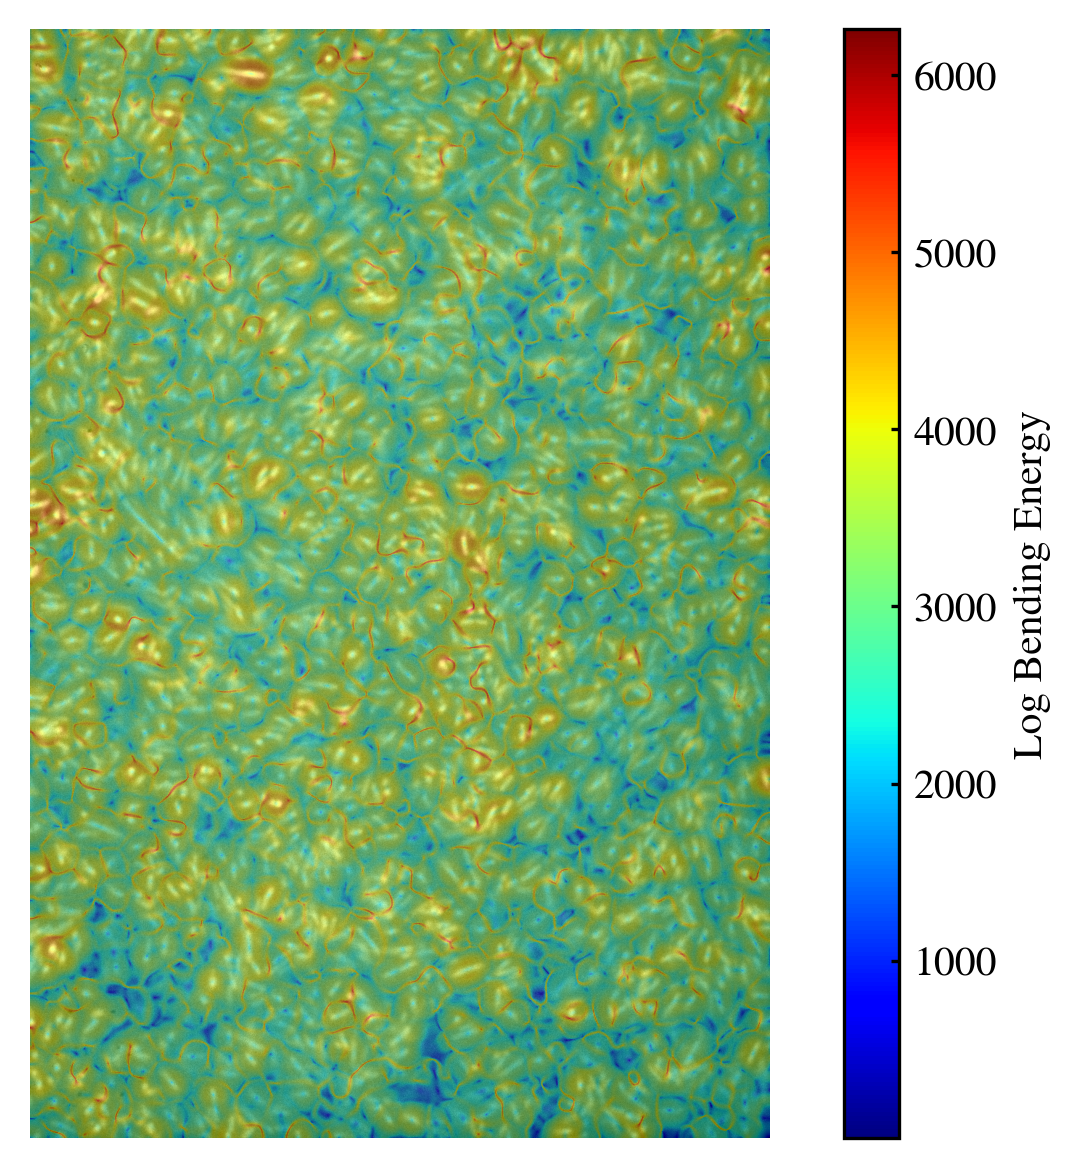

In [39]:
fig, ax = plt.subplots(dpi=300)
ax.imshow(img, cmap='gray')
ax.imshow(np.log(be), cmap='jet', alpha=0.5)  # Adjust alpha for transparency
# colorbar
sm = plt.cm.ScalarMappable(cmap='jet')
sm.set_array(be)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Log Bending Energy')
ax.axis('off')